# 2.4.6: The Coffee Cooling Problem: Mixing

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
# @title
import pandas as pd
import numpy as np

def change_func(t, T, system):
    r, T_env, dt = system['r'], system['T_env'], system['dt']
    deltaT = -r * (T - T_env) * dt
    return deltaT

def run_simulation(system, change_func):

    t_array = np.arange(0, system['t_end']+1, system['dt'])
    n = len(t_array)

    results = pd.Series(index=t_array,dtype=object)
    results.index.name = 'Time (m)'
    results.name = 'Temp (C)'
    results.iloc[0] = system['T_init']

    for i in range(n-1):
        t = t_array[i]
        T = results.iloc[i]
        results.iloc[i+1] = T + change_func(t, T, system)

    system['T_final'] = results.iloc[-1]
    return results

We've simulated the coffee cooling, and we've simulated the milk warming. Now let's put them together!

<br>


<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/2_4/literally.PNG width = 400>


In this notebook we'll write a function that simulates mixing the two liquids, and use it to answer the question we started with: is it better to mix the coffee and milk at the beginning, the end, or somewhere in the middle?

## Iteration: Adding Mixing to the Mix

To solve the problem, we need tools to do three steps:

<br>

* Find the change in temperature of the individual components for a given amount of time
* Find the change in temperature that results from mixing the two liquids
* Find the change in temperature of the mixed liquids for the remaining time

<br>

If we plan well, we should be able to use the same functions to do step 1 and 3: we just have to be careful to define the masses, specific heats and $r$ value for the liquids.   But we'll need a new function to model the mixing process.

### The physics of mixing liquids

When we mix two liquids, the temperature of the mixture depends on the
temperatures of the ingredients as well as their volumes, densities, and specific heat capacities.  Assuming there are no chemical reactions that either produce or consume heat, the total thermal energy of the system is the same before and after mixing; in other words, thermal energy is *conserved*.

<br>

If the temperature of the first liquid is $T_1$, the temperature of the second liquid is $T_2$, and the final temperature of the mixture is $T$, the heat transfer into the first liquid is $C_1 (T - T_1)$ and the heat transfer into the second liquid is $C_2 (T - T_2)$, where $C_1$ and $C_2$ are the thermal masses $m~c_p$ of the liquids.

<br>

In order to keep the total energy the same, the heat lost by the coffee must equal the heat gained by the milk.  In other words, these heat transfers must add up to 0:

<br>

$$C_{coffee} (T - T_{coffee}) + C_{milk} (T - T_{milk}) = 0$$

<br>

We can solve this equation for T:

<br>

$$T = \frac{C_c T_c + C_m T_m}{C_c + C_m}$$

<br>

For the coffee cooling problem, we have the volume of each liquid; if we also know the density, $\rho$, and the specific heat capacity, $c_p$, we can compute thermal mass:

<br>

$$C = \rho V c_p$$

<br>

If the liquids have the same density and heat capacity, they drop out of the equation, and we can write:

<br>

$$T = \frac{V_c T_c + V_m T_m}{V_c + V_m}$$

<br>

where $V_c$ and $V_m$ are the volumes of the liquids.  Milk and coffee are both mostly water, so it fair to assume that they that have the same
density and specific heat.

---

<br>

🟨 🟨  Active reading

We have assumed that milk, water, and coffee all have the same density and specific heat.  Look up these values for water and milk for both density and specific heat and report them here.  Are these good assumptions?  What is the percentage error (roughly) between our assumed and real values?

✅ ✅  Put your answer here

---

### A function for the mixing process

So now we are ready to simulate the mixing process.  The following function takes two `System` objects, representing the
coffee and milk, and creates a new `System` to represent the mixture:

In [ ]:
def mix(system1, system2):
    # Comment 1
    V1, V2 = system1['volume'], system2['volume']
    T1, T2 = system1['T_final'], system2['T_final']

    # Comment 2
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix

    # Comment 3
    mixed_system = dict(T_init=T_mix, T_env=system1['T_env'],T_final = T_mix,
              volume=V_mix, r=system1['r'], t_end=system1['t_end'], dt=system1['dt'])

    # Comment 4
    return mixed_system

This function uses the value of `r` from `system1` as the value of `r`
for the mixture. If `system1` represents the coffee, and we are adding
the milk to the coffee, this is probably a reasonable choice. On the
other hand, when we increase the amount of liquid in the coffee cup,
that might change `r`. So this is an assumption we might want to
revisit.

---

<br>

🟨 🟨  Active Reading

Add 4 comments to the function `mix` to explain the 4 sections of the function (Remember: comment lines should have their own line and come before the code on which they are commenting).

---

### Testing the mixture simulation

To start, we'll test the two extreme possibilities: immediately mixing the coffee and milk, and waiting until arrival to mix the liquids.

<br>

First we'll create objects to represent the coffee and milk.
For `r_coffee` and `r_milk`, we'll use the values we found in the previous notebook:

In [ ]:
# Make a system
T_env = 22; t_end = 30;  dt = 1.0

T_init_cof = 90.0
r_coffee = 0.0115
coffee = dict(T_init=T_init_cof, T_env=T_env,T_final = T_init_cof,
              volume=300, r=r_coffee, t_end=t_end, dt=dt)

T_init_milk = 5.0
r_milk = 0.133
milk = dict(T_init=T_init_milk, T_env=T_env, T_final = T_init_milk,
              volume=50, r=r_milk, t_end=t_end, dt=dt)

Now we can mix them and simulate 30 minutes:

In [ ]:
mix_first = mix(coffee, milk)
run_simulation(mix_first, change_func)

mix_first['T_final']

61.48016207445017

The final temperature is 61.5 °C which is still warm enough to be
enjoyable. Would we do any better if we added the milk last?  Let's simulate the coffee and milk separately, and then mix them:

In [ ]:
run_simulation(coffee, change_func)
run_simulation(milk, change_func)
mix_last = mix(coffee, milk)
mix_last['T_final']

63.163122988668995

After mixing, the temperature is 62.9 °C, so it looks like adding the
milk at the end is better.
But is that the best we can do?

### Sweeping the `t_add` parameter

Adding the milk after 30 minutes is better than adding it immediately, but maybe there's something in between that's even better.  To find if there is a better answer in the "middle", we'll need a function that will allow us to run multiple situations during which we mix the liquids at different times. The function takes the time to add the milk, `t_add`, as an argument:

In [ ]:
def run_and_mix(t_add, t_total):
    coffee['t_end'] = t_add
    coffee_results = run_simulation(coffee, change_func)

    milk['t_end'] = t_add
    milk_results = run_simulation(milk, change_func)

    mixture = mix(coffee, milk)
    mixture['t_end'] = t_total - t_add
    results = run_simulation(mixture, change_func)

    return mixture['T_final']

`run_and_mix` simulates both systems for the given time, `t_add`.
Then it mixes them and simulates the mixture for the remaining time, `t_total - t_add`.  When `t_add` is`0`, we add the milk immediately; when `t_add` is `30`, we add it at the end. Now we can sweep the range of values in between:

In [ ]:
sweep = pd.Series([],dtype=object)
for t_add in np.linspace(0, 30, 31):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the results look like:

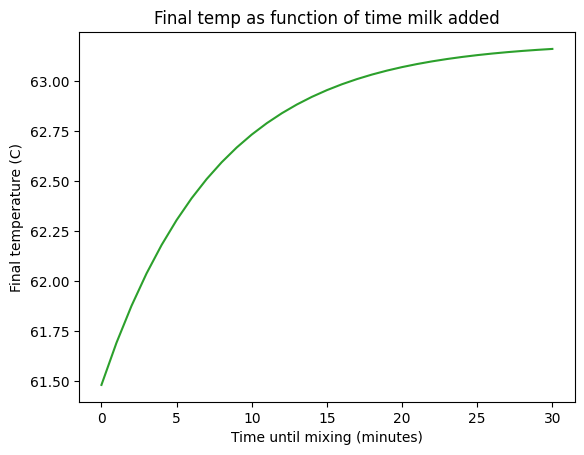

In [ ]:
sweep.plot(label='mixture', color='C2',
           xlabel='Time until mixing (minutes)',
         ylabel='Final temperature (C)',
          title='Final temp as function of time milk added');

Note the values of the x-axis: this shows us final results as a function of `t_add`, not the temperature of the liquid over time.  

---

<br>

🟨 🟨  Active Reading

What is the optimal time to mix the two liquids?  What is the "metric" here?


✅ ✅  Put your answer here

---

## An analytic solution to the coffee problem

Remember that we started with an expression of Newton's law of cooling as a differential equation, and then we discretized that equation to incorporate it into a change function.   But can we just solve it analytically?  

<br>

Here's the differential equation:

<br>

$$\frac{dT}{dt} = -r (T - T_{env})$$


<br>

This equation tells us that he slope of the function $T = f(t)$ will vary with difference in temperature between the liquid and the environment.  If $T > T_env$, then the initial slope will be downward because $r$ is negative: as expected, the temperature of the coffee would go down.  

<br>

So at the next step, the temperature difference will be smaller but still positive, so the slope will be more shallow but still downward.  As the temperature difference gets smaller and smaller, approaching zero, the slope will flatten out.  

<br>

But the opposite would happen if we start with a temperature that is cooler than $T_env$: the slope will initially be large and positive but will gradually become small and positive.

<br>

Here is a image of 9 possible particular solutions, each with a different initial temperature:

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/2_4/Coffee_possible_solutions.PNG width = 600>







So we can see that each of these lines matches the description of our equation: the slope is proportional to the distance of the temperature from $T_{env} = 22 °C$.  

<br>

If we multiply the right side out, we can put Newton's Law in this form:

<br>

$$\frac{dT}{dt} = -rT + rT_{env}$$

<br>

Remembering that $r$ and $T_{env}$ are both constants, we can see that the equation is of this form:

<br>

$$\frac{dT}{dt} = -C_1 T + C_2$$

Answer the question below about this equation.

---

<br>

🟨 Active Reading: Multiple Choice

In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve

location = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/'
folder = 'Support_files/'
name = 'Embedded_Qs.ipynb'
local, _ = urlretrieve(location + folder + name, name)
%run /content/$name

#@title { run: "auto", form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data = display_multC('2_4_DEQ',home,9)
answer = "" # @param ["", "A", "B", "C", "D", "E"]
check_multC(data,answer)

Look at the generalized for of Newton's Law of cooling.  It should look like one of the differential equations we used in the world population notebooks.  Which type of model is Newton's Law of cooling?

A) Linear
B) Proportional
C) Logistic


---

<br>

🟨 Active Reading: Multiple Choice

In [ ]:
#@title { run: "auto", form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data = display_multC('2_4_DEQ',home,10)
answer = "" # @param ["", "A", "B", "C", "D", "E"]
check_multC(data,answer)

The image above entitled "Possible Particular Solutions" describes the physical system (i.e. coffee sitting in an environment).  What does each of these lines represent?

A) The temperature of a cup of coffee over time based on different initial temperatures
B) The temperature of a cup of coffee over time based on different 'r' values
C) The temperature of a cup of coffee over time based on different different mixing times


---